In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

import layers.extra
import losses.extra

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, dirname=dn, multiTrack=multiTrack, r=True)


Importing midi-data

Encoding midi-data
 500
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [6]:
# n = 1000
# min_f = 0
# max_f = 3
# x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
#     n_polyrythms=1,
#     n_channels=3,
#     d_phase=True,
#     return_params=True,
#     dim4=dim4,
#     multiTrack=multiTrack)

In [7]:
x_train.shape

(500, 40, 9, 1)

In [8]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 40, 9, 1), 450)

In [9]:
x_test = x_train[m:]
x_train = x_train[:m]

m (40, 9)


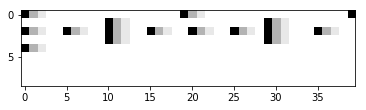

m (40, 9)


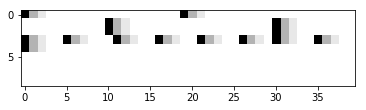

["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"]

In [10]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
# plot.single(x_train[2, :50,:,0])
labels[0:4]

In [11]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(40, 9, 1)

In [12]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [13]:
def sub_encoder(input_shape=(10,3,1), latent_dim=2):
    sub_encoder_input = Input(shape=input_shape, name='sub_encoder_input')
    h = sub_encoder_input
    
    timesteps, notes, channels = input_shape
    
    # Convolution
    k = (2,1)
    s = (2,1)
#     h = Conv2D(32, kernel_size=k, strides=1, activation='relu', padding='valid')(h)
    h = Conv2D(64, kernel_size=k, strides=s, activation='relu', padding='valid')(h)
    h = Conv2D(128, kernel_size=k, strides=s, activation='relu', padding='valid')(h)

#     # input per note
#     note_list = Permute([2,1,3], name='input_per_note')(h)
    
#     rnn = SimpleRNN(128, name='rnn_per_note')
#     reshape = Reshape((128,1))

#     n_capsules = 10
#     capsule_dim = 6
#     n_routings=3
#     share_weights=True
#     capsule = Capsule(n_capsules, capsule_dim, n_routings, share_weights)

#     x = Lambda(lambda layer: capsule(reshape(rnn(layer))) )
#     h_per_note = TimeDistributed(x, name='TimeDistributed_per_note')(note_list)
#     shape = K.int_shape(h_per_note)[1:]
#     h_per_note = Reshape( [notes, np.prod(shape[1:3])] )(h_per_note)
#     h_per_note = Flatten()(h_per_note)

#     # 'global' input
#     h = encoder_input
#     h = Reshape(input_shape[:-1])(h)
#     h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
#     h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
#     h = Conv1D(128, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
#     # old layers
# #     h = Conv2D(1, kernel_size=k, strides=1, activation='relu', padding='valid')(h)
# #     shape = K.int_shape(h)[1:]
# #     h = Reshape(shape[0:2])(h) # (reduced_timesteps, notes)
# #     h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
#     h = SimpleRNN(128)(h)
# #     h = LSTM(256)(h)
# #     h = Bidirectional(LSTM(256)(h))
#     h_global = h
    
#     h = Reshape((-1,1))(h_global) # h_global h_per_note
# #     h = Concatenate(axis=1)([h_global, h_per_note])

# #     h = Reshape((-1,1))(h)
    
#     n_capsules = 10
#     capsule_dim = 6
#     n_routings=3
#     share_weights=True
#     h = Capsule(n_capsules, capsule_dim, n_routings, share_weights)(h)   
    h = Flatten()(h)
    h = Dense(100)(h)
    
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
    z_mean = Reshape((1, latent_dim))(z_mean)
    z_log_var = Reshape((1, latent_dim))(z_log_var)
    h = Concatenate(axis=1)([z_mean, z_log_var])
    sub_encoder_output = h
    sub_encoder_model = Model(sub_encoder_input, sub_encoder_output, name='sub_encoder_model-')
    
    reshaped_mean = Reshape((latent_dim,))(z_mean)
    sub_encoder_mean = Model(sub_encoder_input, reshaped_mean, name='sub_encoder_mean')
#     print('Extra params:', [k.count_params() for k in [rnn, reshape, capsule]])
    return sub_encoder_model, sub_encoder_mean

# class Resample(keras.layers.Layer):
#     def __new__(self, input_shape, length):
#         timesteps, notes, channels = input_shape
#         n = int(timesteps/length)
#         # TODO crop input if incompatible dims
#         # crop((0, timesteps % length))
#         return Reshape((n, length, notes, channels))

def encoder(encoder_input, sub_encoder):
    """ An existing sub_model can be used to return for example just the mean of the 
    latent-coordinates
    """
    h = layers.extra.Resample(input_shape, length)(encoder_input)
    h = TimeDistributed(sub_encoder)(h)
    encoder_output = h
    return Model(encoder_input, encoder_output, name='encoder_model-'), encoder_output

def new_encoder(input_shape, latent_dim=2, length=10):
    """ Create an encoder that encodes a batch of images into a batch of the mean + variance
    of the corresponding latent-coordinates
    """
    encoder_input = Input(shape=input_shape, name='encoder_input-')
    timesteps, notes, channels = input_shape
    sub_shape = (length, notes, channels)
    sub_encoder_model, sub_encoder_mean = sub_encoder(sub_shape, latent_dim) 
    # output_shape  = ([mean], [var])
    model, encoder_output = encoder(encoder_input, sub_encoder_model)
    # output_shape = (batch_size, latent_samples, 2, latent_dim)
    m = (model, sub_encoder_model, sub_encoder_mean)
    return m, encoder_input, encoder_output

In [14]:
latent_samples = 4
length = int(timesteps/latent_samples)
models_, encoder_input, encoder_output = new_encoder(input_shape, latent_dim, length)
encoder_model, sub_encoder_model, sub_encoder_mean = models_
sub_encoder_model.summary()
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sub_encoder_input (InputLayer)  (None, 10, 9, 1)     0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 9, 64)     192         sub_encoder_input[0][0]          
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 9, 128)    16512       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2304)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [15]:
def sample(z_mean, z_log_var, latent_dim=2, epsilon_std=1.):
    epsilon = K.random_normal(
        shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

   
def sampleSequence(latent_dim=2., epsilon_std=1.):
    # iterate batch_samples, in this case this is equal to iterating the latent_samples 
    # map_fn(fn, values) -> [values.shape[0]] + fn(values[0]).shape
    return lambda layers: K.map_fn(lambda args: sample(args[:,0], args[:,1], latent_dim, epsilon_std), layers)

In [16]:
# sample_ = lambda layers: K.map_fn(lambda args: sample(args, latent_dim, epsilon_std), layers)
# sample_ = lambda args: sample(args, latent_dim, epsilon_std)

In [17]:
z_input = encoder_model(encoder_input)
sample_ = sampleSequence(latent_dim, epsilon_std)
z_output = Lambda(sample_, name='sample_z-')(z_input)

In [18]:
K.int_shape(encoder_output)

(None, 4, 2, 3)

In [19]:
K.int_shape(z_output)

(None, 4, 3)

In [20]:
K.shape(z_input)

<tf.Tensor 'Shape:0' shape=(4,) dtype=int32>

In [21]:
def list_sub_decoders(output_shape):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape
    filters = 64
#     output_shape = (14, 14, filters)
#     output_shape = (timesteps, notes, 1)
    
    # keras.examples.variational_autoencoder_deconv.py
    decoders = []
    decoders += [ Dense(100) ]
    decoders += [ LeakyReLU(alpha=0.3) ]
    
#     # add a bypass layer
#     w = 256
#     decoders += [ Dense(w, activation='relu') ]
#     extra_decoders = []
#     for _ in range(3):
#         extra_decoders += [ Dense(w, activation='elu', bias_initializer='zeros') ]

#     extra_d = Lambda(lambda layer: utils.composition(extra_decoders, layer))
#     decoders += [ Lambda(lambda layer: Add()([layer, extra_d(layer)])) ]
    
#     decoders += [ BatchNormalization(momentum=0.5) ]

#     # Shared Layers (Conductor)
    
#     # +1 is used to produce an extra input for the first embedding-decoder    
#     dim1, dim2, filters = 4+1, int(timesteps/4), notes*4
#     print('dim1: %i dim2: %i filters: %i' % (dim1, dim2, filters))
#     decoders += [ Dense(dim1*dim2, activation='tanh', name='conductor') ] # stddev = 0.001 in musicVAE
#     decoders += [ BatchNormalization(momentum=0.3) ]
    
#     decoders += [ Reshape((dim1, dim2, 1)) ]
#     # TODO CudnnLSTM to run on gpu
#     conductor_lstm = LSTM(filters, return_sequences=True) # dropout = ..
#     decoders += [ TimeDistributed(conductor_lstm) ]
    
    
#     # Shared Decoders
    
#     # The first 2 embeddings are fed into embedding_decoder1 (TODO + gen. initial state?)
#     # The next decoders get the i-th embedding + the (i-1)-th embedding
    
# #     decoders += [ Reshape((dim1, dim2, filters)) ]
#     decoders += [ Reshape((dim1, dim2*filters), name='embeddings') ]
#     w = 100 # filters
# #     decoders += [ TimeDistributed(Dense(w, activation='tanh'))]
    
#     dim1 -= 1
#     embedding_selectors = []
#     for i in range(dim1):
#         # Keep 2 embeddings per layer
#         # Note that the second index is right-oriented (css style)
#         j = dim1 - i - 1
#         print(dim1, i, j)        
#         # shape = (2, dim2*filters)
#         embedding_selectors += [ Cropping1D((i,j)) ]
#     print(len(embedding_selectors))
#     print('dim1: %i' % dim1, [(i,i+2) for i in range(dim1-1)])
    
#     # reshape: [x1,x2] -> [ concat[x1,x1] ] :: (2,x) -> (1, 2*x)
#     # reshape_e = Reshape((1, 2*dim2*filters))
#     reshape_e = Reshape((1, 2*dim2, filters))

    
#     # \layer -> map (\f -> f layer) [f1, f2, f3]
#     split_embeddings = Lambda(lambda layer: list(map(lambda f: reshape_e(f(layer)), embedding_selectors)))
#     decoders += [ split_embeddings ]
#     decoders += [ Concatenate(axis=1) ]
    
#     # For every embedding tuple (previous, current)
#     #  put the samples respectively in the RNN
#     #  then keep the second half of the sequences
#     # input_shape = dim1 x (1,2*dim2*filters)
#     # TODO CudnnLSTM to run on gpu
#     lstm1 = LSTM(100, return_sequences=True)
#     crop = Cropping1D((dim2,0))
#     # lstm2(100, return_sequences=True)
#     embedding_decoder = Lambda(lambda layer: crop(lstm1((layer))))
#     decoders += [ TimeDistributed(embedding_decoder) ]
#     # TODO ? instead of weird embedding-splitting, reuse the initial state of the previous lstm

#     decoders += [ Reshape((dim1*dim2, 100)) ]
#     decoders += [ TimeDistributed(Dense(notes, activation='sigmoid')) ]
#     decoders += [ Reshape((timesteps, notes, 1)) ]

    decoders += [ Dense(np.prod(output_shape), activation='sigmoid') ]
    decoders += [ Reshape(output_shape) ]
    return decoders

    
def list_decoders(output_shape, latent_length=8):
    timesteps, notes, channels = output_shape
    shape = (latent_length, notes, channels)
    
    decoders = []
    sub = Lambda(lambda layer: utils.composition(list_sub_decoders(shape), layer, verbose=False))
    sub = Dense(9, activation='relu', name='fl')
    decoders += [ TimeDistributed(sub) ]
    decoders += [ Flatten() ]
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid') ]
    decoders += [ Reshape(output_shape) ]
    
    return decoders

In [22]:
decoders = list_decoders(input_shape)

In [23]:
decoded = utils.composition(decoders, z_output, verbose=False)
# layer1, = layers

In [24]:
K.int_shape(z_output)

(None, 4, 3)

In [25]:
K.shape(z_output)

<tf.Tensor 'Shape_1:0' shape=(3,) dtype=int32>

In [26]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input- (InputLayer)  (None, 40, 9, 1)          0         
_________________________________________________________________
encoder_model- (Model)       (None, 4, 2, 3)           247810    
_________________________________________________________________
sample_z- (Lambda)           (None, 4, 3)              0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 9)              36        
_________________________________________________________________
flatten_2 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 360)               13320     
_________________________________________________________________
reshape_5 (Reshape)          (None, 40, 9, 1)          0         
Total para

In [27]:
def vae_loss(beta=1.):
#     beta = ((1.0 - tf.pow(hparams.beta_rate, tf.to_float(self.global_step)))
#             * hparams.max_beta)
#     self.loss = tf.reduce_mean(r_loss) + beta * tf.reduce_mean(kl_cost)
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    # kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

    # :encoder_output :: (batch_size, latent_samples, 2, latent_dim)
    mean_list = encoder_output[:,:,0]
    var_list = encoder_output[:,:,1]
    reduced_mean = K.max(mean_list, axis=1)
    reduced_var = K.max(var_list, axis=1)
#     print(K.int_shape(encoder_output))
#     print(K.int_shape(mean_list))
#     print(K.int_shape(reduced_mean))
    kl_loss_ = losses.extra.kl_loss(reduced_mean, reduced_var)

    
    # TODO minimize the amount of movement in the latent space
    # interpolation_loss =
    
    # max(kl_per_sample) gives the best score, but the mean should give a smooth gradient
    # kl_loss = sum(a * mean(foreach(kl_) + b * max(foreach(kl_))
    
    # kl_loss = max(kl_loss, free_bits)
    vae_loss = K.mean(xent_loss + beta * kl_loss_)
    return vae_loss

vae_loss = vae_loss(beta=1)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Output "reshape_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_5" during training.


In [28]:
batch_size = 100
epochs = 25
params = {'batch_size': batch_size, 'return_y': False}

In [29]:
phase_mod = 0.01
whitening = False

In [30]:
m = 100
useDataGenerator = False
useDataGenerator = True

x = x_train
x = np.concatenate([x_train[:m] for _ in range(100)])
print('x:', x.shape)

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
#             x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None))
    history = h.history

x: (10000, 40, 9, 1)
batch_size = 100

[Epoch 0/25] >>>>>>>>>
 Batch 0/4
 \_val_loss [244.0]
 \_loss [249.0]
 Batch 1/4
 \_val_loss [234.0]
 \_loss [241.0]
 Batch 2/4
 \_val_loss [218.0]
 \_loss [230.0]
 Batch 3/4
 \_val_loss [208.0]
 \_loss [209.0]
 Batch 4/4
 \_val_loss [184.0]
 \_loss [189.0]

[Epoch 1/25] >>>>>>>>>
 Batch 0/4
 \_val_loss [166.0]
 \_loss [166.0]
 Batch 1/4
 \_val_loss [154.0]
 \_loss [149.0]
 Batch 2/4
 \_val_loss [145.0]
 \_loss [131.0]
 Batch 3/4
 \_val_loss [140.0]
 \_loss [121.0]
 Batch 4/4
 \_val_loss [132.0]
 \_loss [110.0]

[Epoch 2/25] >>>>>>>>>
 Batch 0/4
 \_val_loss [120.0]
 \_loss [106.0]
 Batch 1/4
 \_val_loss [117.0]
 \_loss [96.0]
 Batch 2/4
 \_val_loss [126.0]
 \_loss [93.0]
 Batch 3/4
 \_val_loss [122.0]
 \_loss [89.0]
 Batch 4/4
 \_val_loss [115.0]
 \_loss [87.0]

[Epoch 3/25] >>>>>>>>>
 Batch 0/4
 \_val_loss [112.0]
 \_loss [85.0]
 Batch 1/4
 \_val_loss [109.0]
 \_loss [82.0]
 Batch 2/4
 \_val_loss [113.0]
 \_loss [81.0]
 Batch 3/4
 \_val_loss [114

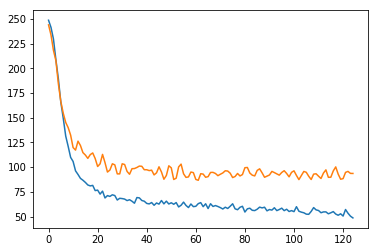

In [31]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [52]:
x.shape

(10, 40, 9, 1)

m (40, 9)


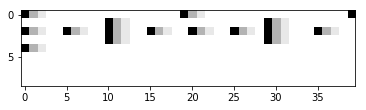

m (40, 9)


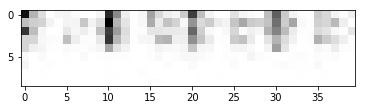

m (40, 9)


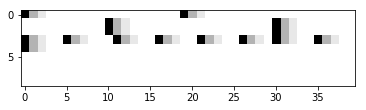

m (40, 9)


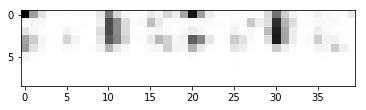

m (40, 9)


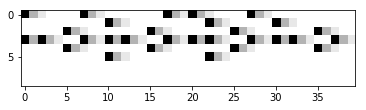

m (40, 9)


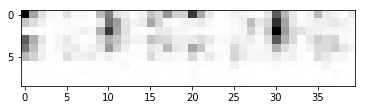

In [33]:
i = 0
j = 1
k = -1
x = vae.predict(x_train[:100])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(x_train[k, :50, :, 0])
plot.single(x[k, :50, :, 0])

m (40, 9)


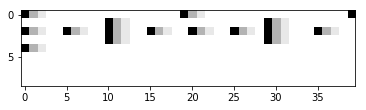

m (40, 9)


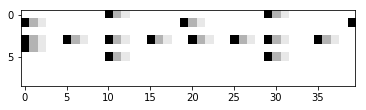

m (40, 9)


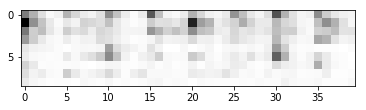

In [53]:
x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
i = 0
plot.single(x_train[i,:,:,0])
plot.single(x[i,:,:,0])
x_ = vae.predict(x)
plot.single(x_[i,:,:,0])

In [54]:
x.shape

(10, 40, 9, 1)

m (30, 9)


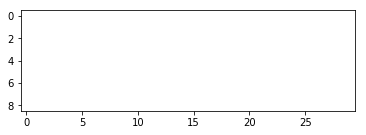

In [55]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 9)


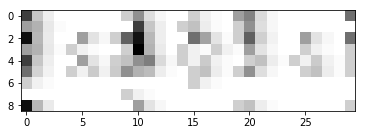

In [37]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [38]:
# build a model to project inputs on the latent space
# encoder = Model(encoder_input, z_mean)
encoder, _ = encoder(encoder_input, sub_encoder_mean)

In [39]:
x_test.shape

(50, 40, 9, 1)

In [40]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 4, 3)

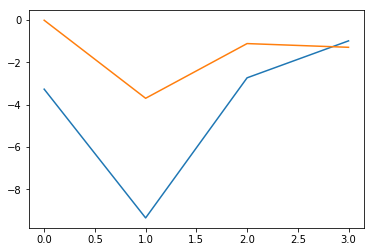

In [41]:
# shape = (samples, latent_samples, mean, latent_dim)
plt.plot(x_train_encoded[0,:,0])
plt.plot(x_train_encoded[0,:,1])

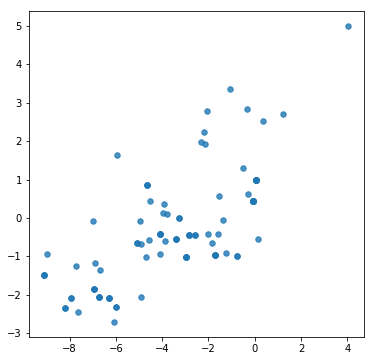

In [42]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:,0,0], x_train_encoded[:,0,1], alpha=0.8, s=30) # c=y_test, 

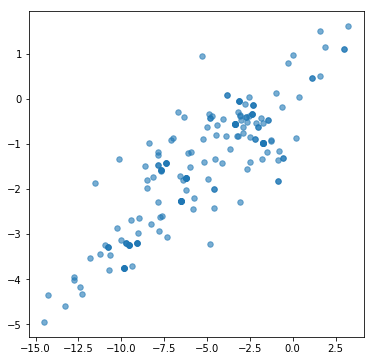

In [43]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,:,0], x_test_encoded[:,:,1], alpha=0.6, s=30) # , c=y_test
# plt.colorbar()

In [44]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_samples,latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

m (40, 9)


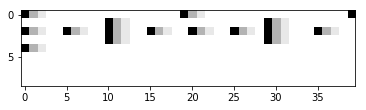

m (40, 9)


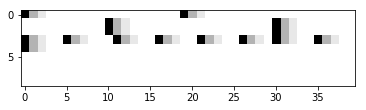

m (40, 9)


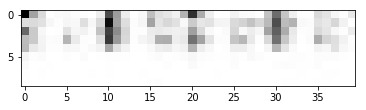

In [45]:
a = 0.8
x2 = (x_train[0] * a + x_train[1] * (1-a)).reshape(1, timesteps, notes,1)
result = generator.predict((encoder.predict(x2)))
plot.single(x_train[0,:,:,0])
plot.single(x_train[1,:,:,0])
plot.single(result[0,:,:,0])

m (40, 9)


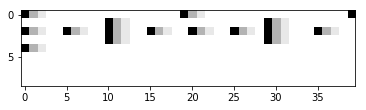

m (40, 9)


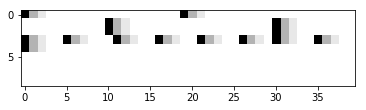

m (40, 9)


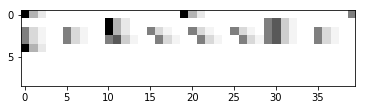

m (40, 9)


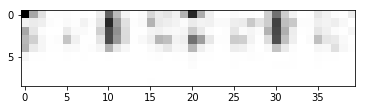

In [46]:
f1 = lambda x: x.mean(axis=0).reshape(1, latent_samples, latent_dim)
f2 = lambda x: x.mean(axis=0).reshape(timesteps, notes)
ls = encoder.predict(x_train[:2])
# z = ls.mean(axis=0).reshape(1, latent_samples, latent_dim)
result = generator.predict(f1(ls))
plot.single(x_train[0,:,:,0])
plot.single(x_train[1,:,:,0])
plot.single(f2(x_train[:2]))
plot.single(result[0,:,:,0])

In [47]:
# x_decoded[0].reshape(150,3)

In [48]:
x_train.shape

(450, 40, 9, 1)

In [49]:
def latent(generator,
           batch_size=2,
           latent_dim=2,
           x_encoded=0.,
           latent_indices=(0, 1),
           n=10,
           m=4,
           crop_size=30,
           margin_top=1,
           margin_left=1,
           min_x=0.05,
           max_x=0.95,
           min_y=0.05,
           max_y=0.95):
    """ Original: keras.keras.examples.variational_autoencoder
    :x_encoded :: float | [ float ]
    """
    if not isinstance(x_encoded, np.ndarray):
        x_encoded = np.repeat(x_encoded, latent_dim)
    print(x_encoded.shape, x_encoded)
    x_decoded = generator.predict(x_encoded.reshape([1, latent_dim]))

    # display a 2D manifold of output samples
    size1 = x_decoded.shape[2]
    size2 = crop_size  # crop x_train.shape[1]
    margin_y, margin_x = n * margin_top * 3, m * margin_left * 3
    figure = np.zeros((size1 * n + margin_y, size2 * m + margin_x))
    # linearly spaced coordinates on the unit square were transformed through
    # the inverse CDF (ppf) of the Gaussian to produce values of the latent
    # variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(min_x, max_x, n))
    grid_y = norm.ppf(np.linspace(min_y, max_y, m))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = x_encoded.copy()
            z_sample[np.array(latent_indices)] = (xi, yi)
            # z_sample = np.array([[yi, xi]])
            # TODO check whether batch_size influences the generator output
            z_sample = np.tile(z_sample, batch_size).reshape(
                batch_size, latent_dim)
            x_decoded = generator.predict(z_sample, batch_size=batch_size)
            sample = x_decoded[0, :size2].reshape((size2, size1)).transpose()
            sample.reshape(size1, size2)
            # coordinates of the current sample
            a = i * size1 + i * margin_top * 3
            b = (i + 1) * size1 + i * margin_top * 3
            c = j * size2 + j * margin_left * 3
            d = (j + 1) * size2 + j * margin_left * 3
            # table separators (partially overlapping)
            figure[a, :] = 0
            figure[a + 1, 1:-1] = 0.3
            figure[a + 2, :] = 0
            figure[:, c] = 0
            figure[1:, c + 1] = 0.3
            figure[:, c + 2] = 0
            a, b, c, d = a + 3, b + 3, c + 3, d + 3
            figure[a:b, c:d] = sample

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray_r')
    plt.show()

In [50]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(3,) [0. 0. 0.]


ValueError: Error when checking : expected input_1 to have 3 dimensions, but got array with shape (1, 3)

In [ ]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)